# A bioeconomic model for the optimization of local canine rabies control
#### Aaron Anderson

This notebook presents a model that can be used to maximize the impact of whatever canine rabies management resources are available at the local level. The model is an individual-based, stochastic simulation model that explicitly accounts for the links between management effort, management cost, and biological outcomes. The version of the model presented below was parameterized for a population of owned, largely free-roaming dogs in a low-income community in the village of Hluvukani, Mpumalanga Province, South Africa.

There are several key characteristics of the model:
* The model tracks individual dogs and their traits through time. This is performed via a matrix that contains a row for each individual and a column for each trait associated with individuals. 
* The model operates on a daily time step. This minimizes bias that results from discrete time steps, and allows the model to more precisely consider management efforts that vary temporally. 
* Many of the processes that occur in the model are stochastic. A stochastic model provides important benefits because it allows a user to examine the tradeoffs between management costs and the certainty with which a management goal is successfully achieved. 
* The model allows nearly any combination of vaccination, fertility control, and removal, and these treatments can be demographic-specific. 
* The model separates the cost of capturing or contacting dogs and the cost of applying the treatment. Notably, the user can easily specify a non-linear relationship between the cost of capturing dogs and the number of dogs captured. The separation of costs and ability to specify non-linear capture costs are critical to a proper understanding of the economics of management.



#### Notebook outline
1. Install and load required packages
2. Specify parameter values
3. Pre-simulation calculations and assignments
4. Mechanism functions
5. Iteration loop
6. Numerical results
7. Plotted results

---
## 1. Install and load required packages 
This may take several minutes.

In [1]:
# view terminal to see progress
require('ggplot2')
library(ggplot2)

Loading required package: ggplot2


---
## 2. Specify parameter values
The parameters below should be adjusted by the user to reflect the application.

In [2]:
# set the seed for random number generation to ensure results are replicable
set.seed(1111)

# inputs for simulation
simulationYears <- 5
simulationEnd   <- 365 * simulationYears
iterations      <- 5

# inputs for initial population
initialPopSize    <- 463
initialFracAdult  <- 0.61
initialFracPup    <- 0.33
initialFracFemale <- 0.38
initialFracImmune <- 0.0
initialFracContra <- 0.0
initialFracVacc   <- 0.0
initialFracSter   <- 0.0

# inputs for mortality
maxJuvAge          <- 299
maxPuppyAge        <- 89
maxAge             <- 4000
carryingCap        <- 577
pupAnnMortProb     <- 0.90
juvAnnMortProb     <- 0.63
adultAnnMortProb   <- 0.32
emigrationProb     <- 0

# inputs for reproduction
immigrantDogs        <- 131
expectedLittersPFY   <- 0.31
expLitterPer <- expectedLittersPFY
meanLitterSize       <- 4.4
femalePupProb        <- 0.38
fractionBirthPulse   <- 0.0
birthPulseVector     <- rep(0, 12)
birthPulseVector[1]  <- 0 
birthPulseVector[2]  <- 0 
birthPulseVector[3]  <- 0
birthPulseVector[4]  <- 0 
birthPulseVector[5]  <- 0 
birthPulseVector[6]  <- 0 
birthPulseVector[7]  <- 0
birthPulseVector[8]  <- 0
birthPulseVector[9]  <- 0 
birthPulseVector[10] <- 0 
birthPulseVector[11] <- 0 
birthPulseVector[12] <- 0 

# inputs for disease
monthsOfPressure      <- 1
dogsPerMonthExposed   <- 1
monthInitIntroduction <- 25
transmissionParam     <- 2.15
bitesPerRabidMean <- transmissionParam
bitesPerRabidShape    <- 1.33
probInfectionFromBite <- 0.49
survivalProb          <- 0
exposedTimeShape      <- 1.08549138
exposedTimeRate       <- 0.04919551
infectiveTimeShape    <- 2.831788
infectiveTimeRate     <- 0.9193612

# inputs for benefits of management
bitesPerNonRabid     <- 0.00006 
bitesPerRabid        <- 0.02252 
PEPperNonRabidBite   <- 0.991
PEPperRabidBite      <- 0.991
costPerPEP           <- 754.92
lifeLossPerRabidBite <- 0.19

# inputs for treatment costs
vaccineCost             <- 2.426
contraceptionCostFemale <- 150
contraceptionCostMale   <- 150
sterilizationCostFemale <- 300
sterilizationCostMale   <- 200
euthanasiaCost          <- 150

# inputs for effectiveness of contraception and vaccination
timeVaccineEffective       <- 730
timeBoosterEffective       <- 1095
timeContraEffectiveMales   <- 730
timeContraEffectiveFemales <- 730

# inputs for contact costs
# note: 25, 50, 75, 100, mean 25% 50%, 75%, 100% of specified 
#       initial abundance
contactCost25  <- 1019.09
contactCost50  <- 2757.3
contactCost75  <- 4735.89
contactCost100 <- 8453.7

# input for budget years 1-5    
annualBudget     <- rep(0, simulationYears)
annualBudget[1]  <- 40000/5
annualBudget[2]  <- 40000/5
annualBudget[3]  <- 40000/5
annualBudget[4]  <- 40000/5
annualBudget[5]  <- 40000/5

# inputs for strategy  
# note: model assumes already sterilized dogs are not re-sterilized. 
#       Within the same year dogs will not be vaccinated or contracepted 
#       twice. If dogs are re-contancted in a future year, they will be 
#       re-vaccinated or re-contracepted
# note: contraception and sterilization cannot both equal 1 for same 
#       demographic
# note: if euthanisia equal 1 for some demographic, 
#       all other treatments must equal zero  
vaccPuppyMale     <- 1
vaccPuppyFemale   <- 1
vaccAdultMale     <- 1
vaccAdultFemale   <- 1
vaccJuvMale       <- 1
vaccJuvFemale     <- 1
contraPuppyMale   <- 0
contraPuppyFemale <- 0
contraAdultMale   <- 0
contraAdultFemale <- 0
contraJuvMale     <- 0
contraJuvFemale   <- 0
sterPuppyMale     <- 0
sterPuppyFemale   <- 0
sterAdultMale     <- 0
sterAdultFemale   <- 1
sterJuvMale       <- 0
sterJuvFemale     <- 1
euthPuppyMale     <- 0
euthPuppyFemale   <- 0
euthAdultMale     <- 0
euthAdultFemale   <- 0
euthJuvMale       <- 0
euthJuvFemale     <- 0

boosterGiven <- TRUE

# inputs for management timing
mgtMonthVector     <- rep(0, 12)
mgtMonthVector[1]  <- 0 
mgtMonthVector[2]  <- 0 
mgtMonthVector[3]  <- 0
mgtMonthVector[4]  <- 1
mgtMonthVector[5]  <- 0
mgtMonthVector[6]  <- 0
mgtMonthVector[7]  <- 0
mgtMonthVector[8]  <- 0
mgtMonthVector[9]  <- 0
mgtMonthVector[10] <- 0
mgtMonthVector[11] <- 0
mgtMonthVector[12] <- 0

## 3. Pre-simulation calculations and assignments

In [3]:
# Get total number of days in simulation:
simulationEnd   <- 365 * simulationYears

# A vector of month number for use in seasonal timing:
monthSeries <- c(rep(1, 31), rep(2, 28), rep(3, 31), rep(4, 30), 
                 rep(5, 31), rep(6, 30), rep(7, 31), rep(8, 31),
                 rep(9, 30), rep(10, 31), rep(11, 30), rep(12, 31)) 

monthFirstDays <- rep(c(match(1, monthSeries), match(2, monthSeries), match(3, monthSeries), match(4, monthSeries),
                        match(5, monthSeries), match(6, monthSeries), match(7, monthSeries), match(8, monthSeries),
                        match(9, monthSeries), match(10, monthSeries), match(11, monthSeries), match(12, monthSeries)),
                      simulationYears)

# Get days of each year that disease will be introduced:
pressureMonths <- seq(monthInitIntroduction, monthInitIntroduction + monthsOfPressure - 1)  
pressureYears <- (pressureMonths - 1) %/% 12 + 1
pressureDays <- list()
for (i in 1:simulationYears) {
  if (sum(pressureYears == i) > 0) {
    pressureDays[[i]] <- monthFirstDays[pressureMonths[pressureYears == i]]
  } else {
    pressureDays[[i]] <- 0
  }
}
flush.console()

# Calculate demographics of initial population:
initialAdults     <- round(initialFracAdult * initialPopSize)
initialSubAdults  <- initialPopSize - initialAdults
initialPuppies    <- round(initialFracPup * initialSubAdults)
initialJuveniles  <- initialSubAdults - initialPuppies

# Calculate daily mortality probabilities:
pupMortalityProb   <- 1 - (1 - pupAnnMortProb) ^ (1/365)
juvMortalityProb   <- 1 - (1 - juvAnnMortProb) ^ (1/365)
adultMortalityProb <- 1 - (1 - adultAnnMortProb) ^ (1/365)

# Calculate daily litter probabilities:
monthDayCount <- c(31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
if(sum(birthPulseVector) != 12 & sum(birthPulseVector != 0)) {
  peakDays <- sum(birthPulseVector * monthDayCount)
  peakProb <- (fractionBirthPulse * expLitterPer) / peakDays
  offPeakDays <- sum((!birthPulseVector) * monthDayCount)
  offPeakProb <- ((1-fractionBirthPulse) * expLitterPer) / offPeakDays
  litterProbability <- rep(offPeakProb, 365)
  for(m in 1:12) {
    if(birthPulseVector[m] == 1) {
      litterProbability[monthSeries == m] <- peakProb
    }
  }
} else {
  litterProbability <- rep(expLitterPer / 365, 365)
}

# Calculate marginal costs of contact:
marginalCost1 <- contactCost25 / (initialPopSize * 0.25)
marginalCost2 <- contactCost50 / (initialPopSize * 0.25)
marginalCost3 <- contactCost75 / (initialPopSize * 0.25)
marginalCost4 <- contactCost100 / (initialPopSize * 0.25)
marginalCost <- c(marginalCost1, marginalCost2, marginalCost3, marginalCost4)

# List days that management will occur:
mgtDayVector <- rep(0, 365)
for(m in 1:12) {
  if(mgtMonthVector[m] == 1) {
    mgtDayVector[monthSeries == m] <- 1
  }
}
managementDays <- seq(1, 365)
managementDays <- managementDays[mgtDayVector == 1]

# A list of traits in the population matrix:
traitList <- c('age', 'puppy', 'adult','female',
               'sterilized', 'contracepted', 'timeContra',
               'vaccinated', 'timeVacc',
               'boosted', 'contacted', 'contactCost',
               'exposed', 'timeExposed', 'timeLimitExposed',
               'infective', 'timeInfective', 'timeLimitInfective',
               'immune', 'month')

# A list of results that will be tracked:
censusSeries <- c('abundance', 'puppy', 'adult', 'females', 
                  'sterilized', 'femalesSterilized',
                  'contracepted', 'femalesContracepted', 
                  'vaccinated', 'immune', 'exposed', 'infective',
                  'PEPs', 'lifeLoss', 'newlyVaccinated') 
censusVector <- rep(0, length(censusSeries))
names(censusVector) <- censusSeries

# Create a 3d array to store results:
resultsMatrix <- array(data=NA, dim=c(simulationEnd, length(censusSeries), iterations))
colnames(resultsMatrix) <- censusSeries

# Create a vector of binary strategy indicators:
strategyNames <- c('vaccPuppyMale', 'vaccPuppyFemale',
                   'vaccAdultMale', 'vaccAdultFemale', 
                   'vaccJuvMale', 'vaccJuvFemale',
                   'contraPuppyMale', 'contraPuppyFemale',
                   'contraAdultMale', 'contraAdultFemale',
                   'contraJuvMale', 'contraJuvFemale',
                   'sterPuppyMale', 'sterPuppyFemale',
                   'sterAdultMale', 'sterAdultFemale', 
                   'sterJuvMale', 'sterJuvFemale',
                   'euthPuppyMale', 'euthPuppyFemale',
                   'euthAdultMale', 'euthAdultFemale', 
                   'euthJuvMale', 'euthJuvFemale') 
strategyVector <- c(vaccPuppyMale, vaccPuppyFemale,
                    vaccAdultMale, vaccAdultFemale, 
                    vaccJuvMale, vaccJuvFemale,
                    contraPuppyMale, contraPuppyFemale,
                    contraAdultMale, contraAdultFemale, 
                    contraJuvMale, contraJuvFemale,
                    sterPuppyMale, sterPuppyFemale,
                    sterAdultMale, sterAdultFemale, 
                    sterJuvMale, sterJuvFemale,
                    euthPuppyMale, euthPuppyFemale,
                    euthAdultMale, euthAdultFemale, 
                    euthJuvMale, euthJuvFemale)
names(strategyVector) <- strategyNames

# Create a cost vector to indicate unit cost of each strategy:
strategyCostVector <- c(rep(vaccineCost, 6),
                        contraceptionCostMale, contraceptionCostFemale,
                        contraceptionCostMale, contraceptionCostFemale, 
                        contraceptionCostMale, contraceptionCostFemale,
                        sterilizationCostMale, sterilizationCostFemale,
                        sterilizationCostMale, sterilizationCostFemale, 
                        sterilizationCostMale, sterilizationCostFemale,
                        rep(euthanasiaCost, 6))
names(strategyCostVector) <- strategyNames

---
## 4. Mechanism functions
These functions implement the various mechanisms of the model

In [4]:
getDailyBudget <- function(j) {
  # Arguments: The year of the simulation (j)
  # Return:    The amount that can be spent each day given the management months specified and the annual budget
  # Purpose:   Called at the beginning of each year to allocate the budget across management campaigns during year
  dailyBudget <- mgtDayVector * (annualBudget[j] / sum(mgtDayVector))
  return(dailyBudget)
}

In [5]:
InitialPopulation <- function() {
  # Agruments: None.
  # Return:    The population matrix.
  # Purpose:   Construct the initial population matrix.
  
  popMatrix <- matrix(0, nrow=initialPopSize, ncol=length(traitList))
  colnames(popMatrix) <- traitList                 
  popMatrix[, 'age'] <- c(sample(seq(1, maxPuppyAge), initialPuppies, replace=TRUE),
                          sample(seq(maxPuppyAge + 1, maxJuvAge), initialJuveniles, replace=TRUE),
                          sample(seq(maxJuvAge + 1, maxAge), initialAdults, replace=TRUE))
  popMatrix[, 'female'] <- sample(c(0, 1), initialPopSize, replace=TRUE, 
                                  prob=c(1-initialFracFemale, initialFracFemale))
  popMatrix[, 'contracepted'] <- sample(c(0, 1), initialPopSize, replace=TRUE, 
                                        prob=c(1-initialFracContra, initialFracContra))
  popMatrix[, 'sterilized'] <- sample(c(0, 1), initialPopSize, replace=TRUE, 
                                      prob=c(1-initialFracSter, initialFracSter))
  popMatrix[, 'vaccinated'] <- sample(c(0, 1), initialPopSize, replace=TRUE, 
                                      prob=c(1-initialFracVacc, initialFracVacc))
  popMatrix[, 'immune'] <- sample(c(0, 1), initialPopSize, replace=TRUE, 
                                  prob=c(1-initialFracImmune, initialFracImmune))
  popMatrix[popMatrix[, 'contracepted']==1, 'timeContra'] <- 
    vapply(popMatrix[popMatrix[, 'contracepted']==1, 'age'], sample, size=1, FUN.VALUE=0) 
  popMatrix[popMatrix[, 'vaccinated']==1, 'timeVacc'] <- 
    vapply(popMatrix[popMatrix[, 'vaccinated']==1, 'age'], sample, size=1, FUN.VALUE=0)
  popMatrix[popMatrix[, 'age'] > maxJuvAge, 'adult'] <- 1
  popMatrix[popMatrix[, 'age'] <= maxPuppyAge, 'puppy'] <- 1
  popMatrix[, 'month'] <- 1
  popMatrix[, 'contactCost'] <- sample(marginalCost, nrow(popMatrix), replace=TRUE)
  popMatrix[, 'timeLimitExposed'] <- rgamma(nrow(popMatrix), shape=exposedTimeShape, rate=exposedTimeRate)
  popMatrix[, 'timeLimitInfective'] <- rgamma(nrow(popMatrix), shape=infectiveTimeShape, rate=infectiveTimeRate)
  
  return(popMatrix)
}

In [6]:
MortalityFunction <- function() {
  # Arguments: None.
  # Return:    An updated population matrix.
  # Purpose:   Induces out-migration, probabilistic mortality,
  #            old-age mortality, and censors population to carrying capacity.
  
  # Induce out-migration:
  emigDraw  <- runif(nrow(popMatrix))
  popMatrix <- popMatrix[emigDraw > emigrationProb, , drop=FALSE]
  
  # Induce standard and age-related mortality:
  n <- nrow(popMatrix)
  mortProbVector <- rep(adultMortalityProb, n)
  mortProbVector[popMatrix[, 'age'] <= maxJuvAge]  <- juvMortalityProb
  mortProbVector[popMatrix[, 'age'] <= maxPuppyAge] <- pupMortalityProb
  mortDraw <- runif(n)
  popMatrix <- popMatrix[mortDraw > mortProbVector, , drop=FALSE]
  popMatrix <- popMatrix[maxAge > popMatrix[, 'age'], , drop=FALSE]
  
  # Censor the population to carrying capacity:
  n <- nrow(popMatrix)
  mortProbVector <- rep(adultMortalityProb, n)
  mortProbVector[popMatrix[, 'age'] <= maxJuvAge]  <- juvMortalityProb
  mortProbVector[popMatrix[, 'age'] <= maxPuppyAge] <- pupMortalityProb
  survProbVector <- 1 - mortProbVector
  survivors <- sample(seq(1, n), min(carryingCap, n), prob=survProbVector, replace=FALSE)
  popMatrix <- popMatrix[survivors, , drop=FALSE]
  
  return(popMatrix)
}

In [7]:
ReproductionFunction <- function(d) {
  # Arguments: Day of the year.
  # Return:    An updated population matrix.
  # Purpose:   Induces reproduction and adds the new puppies to
  #            the population.
  
  popMatrix[popMatrix[, 'age'] == (maxJuvAge + 1), 'adult'] <- 1
  popMatrix[popMatrix[, 'age'] == (maxPuppyAge +1), 'puppy'] <- 0
  fertFemales <- sum(popMatrix[, 'adult'] == 1 & 
                       popMatrix[, 'female'] == 1 &
                       popMatrix[, 'contracepted'] == 0 &
                       popMatrix[, 'sterilized'] == 0 &
                       (popMatrix[, 'exposed'] + popMatrix[, 'infective'] == 0 | popMatrix[, 'immune'] == 1))
  fertFemales <- max(0, fertFemales)
  litterDraw <- runif(fertFemales)
  puppies <- round(sum(litterDraw < litterProbability[d]) * meanLitterSize)
  newDogMatrix <- matrix(0, nrow=puppies, ncol=length(traitList))
  colnames(newDogMatrix) <- traitList
  newDogMatrix[, 'female'] <- sample(c(0, 1), puppies, 
                                     replace=TRUE, prob=c(1-femalePupProb, 
                                                          femalePupProb))
  newDogMatrix[, 'puppy'] <- 1
  newDogMatrix[, 'contactCost'] <- sample(marginalCost, nrow(newDogMatrix), replace=TRUE)
  newDogMatrix[, 'timeLimitExposed'] <- rgamma(nrow(newDogMatrix), shape=exposedTimeShape, rate=exposedTimeRate)
  newDogMatrix[, 'timeLimitInfective'] <- rgamma(nrow(newDogMatrix), shape=infectiveTimeShape, rate=infectiveTimeRate)
  popMatrix <- rbind(popMatrix, newDogMatrix)
  
  return(popMatrix)
}

In [8]:
ImmigrationFunction <- function() {
  # Arguments: None.
  # Return:    An updated population matrix.
  # Purpose:  Creates immigrant dogs and adds them to the population.
  
  # Calcuate number of new dogs to be added each day:
  newDogCount <- immigrantDogs%/%365
  probNewDog <- (immigrantDogs%%365) / 365
  newDogCount <- newDogCount + (runif(1) < probNewDog)
  
  # Create and add new dogs:
  newDogMatrix <- matrix(0, nrow=newDogCount, ncol=length(traitList))
  colnames(newDogMatrix) <- traitList
  newDogMatrix[, 'female'] <- sample(c(0, 1), newDogCount, 
                                     replace=TRUE, 
                                     prob=c(1-initialFracFemale, 
                                            initialFracFemale))
  newDogMatrix[, 'age'] <- sample(seq(0, maxAge), newDogCount, replace=TRUE)
  newDogMatrix[newDogMatrix[, 'age'] > maxJuvAge, 'adult'] <- 1
  newDogMatrix[newDogMatrix[, 'age'] <= maxPuppyAge, 'puppy'] <- 1
  newDogMatrix[, 'contactCost'] <- sample(marginalCost, nrow(newDogMatrix), replace=TRUE)
  newDogMatrix[, 'timeLimitExposed'] <- rgamma(nrow(newDogMatrix), shape=exposedTimeShape, rate=exposedTimeRate)
  newDogMatrix[, 'timeLimitInfective'] <- rgamma(nrow(newDogMatrix), shape=infectiveTimeShape, rate=infectiveTimeRate)
  popMatrix <- rbind(popMatrix, newDogMatrix)
  
  return(popMatrix)
}

In [9]:
DiseaseSpreadFunction <- function() {
  # Arguments: None.
  # Return:    An updated population matrix.
  # Purpose:   Induces disease transmission, exogenous disease introduction.
  
  # Exogenous transmission:
  if (d %in% pressureDays[[j]]) {
    temp <- rep(0, nrow(popMatrix))
    # Generate a vector of 0's and 1's that indicates which individuals are exposed:
    temp[sample(seq(1, nrow(popMatrix)), dogsPerMonthExposed)] <- 1
    # Change states if the individual can be moved to the exposed state:
    newExposed <- temp == 1 & popMatrix[, 'infective'] == 0 & popMatrix[, 'exposed'] == 0 &
      popMatrix[, 'immune'] == 0 & popMatrix[, 'vaccinated'] == 0
    popMatrix[newExposed, 'exposed']     <- 1
    popMatrix[newExposed, 'timeExposed'] <- 0
  }
  
  # Endogenous transmission:
  infectiveTimes <- popMatrix[popMatrix[, 'infective'] == 1, 'timeLimitInfective']
  if (length(infectiveTimes) > 0) { 
    size <- bitesPerRabidShape / infectiveTimes
    mu <- bitesPerRabidMean / infectiveTimes
    biteMatrix <- mapply(function(x, y){rnbinom(size=x, mu=y, n=1)}, x=size, y=mu)
    dailyRabidBites <- sum(biteMatrix)
  } else{
    dailyRabidBites <- 0
  }
  
  # Now we draw dogs randomly from population to be bitten:
  rowsBitten <- unique(sample(seq(1:nrow(popMatrix)), dailyRabidBites, replace=TRUE))
  bitten <- rep(0, nrow(popMatrix))
  bitten[rowsBitten] <- 1
  infectionDraw <- runif(nrow(popMatrix))
  # Treat dog as unbitten if did not actually aquire infection from bite:
  bitten[infectionDraw > probInfectionFromBite] <- 0
  # Take the dogs that received rabid bites and moved to exposed state if appropriate:
  newExposed <- bitten == 1 & popMatrix[, 'infective'] == 0 & popMatrix[, 'exposed'] == 0 &
    popMatrix[, 'immune'] == 0 & popMatrix[, 'vaccinated'] == 0
  popMatrix[newExposed, 'exposed']     <- 1
  popMatrix[newExposed, 'timeExposed'] <- 0
  
  return(popMatrix)
} 

In [10]:
DiseaseProgressionFunction <- function() {
  # Arguments: None.
  # Return:    An updated population matrix.
  # Purpose:   Induces transition from exposed and infective states.
  
  # Transition exposed to infective:
  newInfective <- popMatrix[, 'exposed'] == 1 & popMatrix[, 'timeExposed'] > popMatrix[, 'timeLimitExposed']
  popMatrix[newInfective, 'exposed']       <- 0
  popMatrix[newInfective, 'infective']     <- 1
  popMatrix[newInfective, 'timeInfective'] <- 0
  
  # Transition infective to death or immune:
  newRecovered <- popMatrix[, 'infective'] == 1 & popMatrix[, 'timeInfective'] > popMatrix[, 'timeLimitInfective']
  recoverDraw <- runif(length(newRecovered))
  recover <- newRecovered[recoverDraw < survivalProb]
  death <- newRecovered[recoverDraw >= survivalProb]
  popMatrix[recover, 'infective'] <- 0
  popMatrix[recover, 'immune']    <- 1
  popMatrix <- popMatrix[!death, , drop=FALSE]
  
  return(popMatrix)
}

In [11]:
ManagementFunction <- function(d, marginalCost, dailyBudget, totalSpending, totalContacted) {
  dailySpending <- 0
  if (dailyBudget[d] > 0) {
    count <- 0
    while (dailySpending < dailyBudget[d] & min(popMatrix[, 'contacted']) == 0) {
      
      # if there are uncontacted dogs left in the lowest marginal cost category, contact them first
      if (sum(popMatrix[, 'contacted'] == 0 & popMatrix[, 'contactCost'] == marginalCost[1]) > 0) {
        dogNumber <- sample(rep(which(popMatrix[, 'contacted'] == 0 & 
                                      popMatrix[, 'contactCost'] == marginalCost[1]), 2), 1)
        # now check for uncontacted in 2nd lowest marginal cost category
      } else if (sum(popMatrix[, 'contacted'] == 0 & popMatrix[, 'contactCost'] == marginalCost[2]) > 0) {
        dogNumber <- sample(rep(which(popMatrix[, 'contacted'] == 0 & 
                                      popMatrix[, 'contactCost'] == marginalCost[2]), 2), 1)
        # and for 2nd highest marginal cost category
      } else if (sum(popMatrix[, 'contacted'] == 0 & popMatrix[, 'contactCost'] == marginalCost[3]) > 0) {
        dogNumber <- sample(rep(which(popMatrix[, 'contacted'] == 0 & 
                                      popMatrix[, 'contactCost'] == marginalCost[3]), 2), 1)
        # and for highest marginal cost category
      } else if (sum(popMatrix[, 'contacted'] == 0 & popMatrix[, 'contactCost'] == marginalCost[4]) > 0) {
        dogNumber <- sample(rep(which(popMatrix[, 'contacted'] == 0 & 
                                      popMatrix[, 'contactCost'] == marginalCost[4]), 2), 1)
      } else {
        break
      }
      
      popMatrix[dogNumber, 'contacted'] <- 1
      totalContacted <- totalContacted + 1
      dailySpending <- dailySpending + as.numeric(popMatrix[dogNumber, 'contactCost'])
      
      if (popMatrix[dogNumber, 'female'] == 1) {
        # FEMALE management starts here
        
        if (popMatrix[dogNumber, 'puppy'] == 1) {
          # female PUPPY management here
          if (strategyVector['euthPuppyFemale'] == 1) {
            popMatrix <- popMatrix[!dogNumber, , drop=FALSE]
            dailySpending <- dailySpending + as.numeric(strategyCostVector['euthPuppyFemale'])
          } else {
            if (strategyVector['sterPuppyFemale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                popMatrix[dogNumber, 'sterilized'] <- 1
                dailySpending <- dailySpending + as.numeric(strategyCostVector['sterPuppyFemale'])
              }
            } else if (strategyVector['contraPuppyFemale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                # we won't contracept if dog has been sterilized, be we will even if already contracepted
                popMatrix[dogNumber, 'contracepted'] <- 1
                popMatrix[dogNumber, 'timeContra'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['contraPuppyFemale'])
              }
            }
            if (strategyVector['vaccPuppyFemale'] == 1) {
              if (popMatrix[dogNumber, 'vaccinated'] == 0) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccPuppyFemale'])
              } else if (boosterGiven == TRUE) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'boosted'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccPuppyFemale'])
              }
            }
          }
        } else if (popMatrix[dogNumber, 'adult'] == 1) {
          # female ADULT management here
          if (strategyVector['euthAdultFemale'] == 1) {
            popMatrix <- popMatrix[!dogNumber, , drop=FALSE]
            dailySpending <- dailySpending + as.numeric(strategyCostVector['euthAdultFemale'])
          } else {
            if (strategyVector['sterAdultFemale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                popMatrix[dogNumber, 'sterilized'] <- 1
                dailySpending <- dailySpending + as.numeric(strategyCostVector['sterAdultFemale'])
              }
            } else if (strategyVector['contraAdultFemale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                # we won't contracept if dog has been sterilized, be we will even if already contracepted
                popMatrix[dogNumber, 'contracepted'] <- 1
                popMatrix[dogNumber, 'timeContra'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['contraAdultFemale'])
              }
            }
            if (strategyVector['vaccAdultFemale'] == 1) {
              if (popMatrix[dogNumber, 'vaccinated'] == 0) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccAdultFemale'])
              } else if (boosterGiven == TRUE) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'boosted'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccAdultFemale'])
              }
            }
          }
        } else {
          # female JUVENILE management here
          if (strategyVector['euthJuvFemale'] == 1) {
            popMatrix <- popMatrix[!dogNumber, , drop=FALSE]
            dailySpending <- dailySpending + as.numeric(strategyCostVector['euthJuvFemale'])
          } else {
            if (strategyVector['sterJuvFemale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                popMatrix[dogNumber, 'sterilized'] <- 1
                dailySpending <- dailySpending + as.numeric(strategyCostVector['sterJuvFemale'])
              }
            } else if (strategyVector['contraJuvFemale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                # we won't contracept if dog has been sterilized, be we will even if already contracepted
                popMatrix[dogNumber, 'contracepted'] <- 1
                popMatrix[dogNumber, 'timeContra'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['contraJuvFemale'])
              }
            }
            if (strategyVector['vaccJuvFemale'] == 1) {
              if (popMatrix[dogNumber, 'vaccinated'] == 0) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccJuvFemale'])
              } else if (boosterGiven == TRUE) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'boosted'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccJuvFemale'])
              }
            }
          }
        } 
        
      } else {
        # MALE management starts here
        if (popMatrix[dogNumber, 'puppy'] == 1) {
          # male PUPPY management here
          if (strategyVector['euthPuppyMale'] == 1) {
            popMatrix <- popMatrix[!dogNumber, , drop=FALSE]
            dailySpending <- dailySpending + as.numeric(strategyCostVector['euthPuppyMale'])
          } else {
            if (strategyVector['sterPuppyMale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                popMatrix[dogNumber, 'sterilized'] <- 1
                dailySpending <- dailySpending + as.numeric(strategyCostVector['sterPuppyMale'])
              }
            } else if (strategyVector['contraPuppyMale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                # we won't contracept if dog has been sterilized, be we will even if already contracepted
                popMatrix[dogNumber, 'contracepted'] <- 1
                popMatrix[dogNumber, 'timeContra'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['contraPuppyMale'])
              }
            }
            if (strategyVector['vaccPuppyMale'] == 1) {
              if (popMatrix[dogNumber, 'vaccinated'] == 0) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccPuppyMale'])
              } else if (boosterGiven == TRUE) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'boosted'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccPuppyMale'])
              }
            }
          }
          
        } else if (popMatrix[dogNumber, 'adult'] == 1) {
          # male ADULT management here
          if (strategyVector['euthAdultMale'] == 1) {
            popMatrix <- popMatrix[!dogNumber, , drop=FALSE]
            dailySpending <- dailySpending + as.numeric(strategyCostVector['euthAdultMale'])
          } else {
            if (strategyVector['sterAdultMale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                popMatrix[dogNumber, 'sterilized'] <- 1
                dailySpending <- dailySpending + as.numeric(strategyCostVector['sterAdultMale'])
              }
            } else if (strategyVector['contraAdultMale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                # we won't contracept if dog has been sterilized, be we will even if already contracepted
                popMatrix[dogNumber, 'contracepted'] <- 1
                popMatrix[dogNumber, 'timeContra'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['contraAdultMale'])
              }
            }
            if (strategyVector['vaccAdultMale'] == 1) {
              if (popMatrix[dogNumber, 'vaccinated'] == 0) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccAdultMale'])
              } else if (boosterGiven == TRUE) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'boosted'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccAdultMale'])
              }
            }
          }
          
        } else {
          # male JUVENILE management here
          if (strategyVector['euthJuvMale'] == 1) {
            popMatrix <- popMatrix[!dogNumber, , drop=FALSE]
            dailySpending <- dailySpending + as.numeric(strategyCostVector['euthJuvMale'])
          } else {
            if (strategyVector['sterJuvMale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                popMatrix[dogNumber, 'sterilized'] <- 1
                dailySpending <- dailySpending + as.numeric(strategyCostVector['sterJuvMale'])
              }
            } else if (strategyVector['contraJuvMale'] == 1) {
              if (popMatrix[dogNumber, 'sterilized'] == 0) {
                # we won't contracept if dog has been sterilized, be we will even if already contracepted
                popMatrix[dogNumber, 'contracepted'] <- 1
                popMatrix[dogNumber, 'timeContra'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['contraJuvMale'])
              }
            }
            if (strategyVector['vaccJuvMale'] == 1) {
              if (popMatrix[dogNumber, 'vaccinated'] == 0) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccJuvMale'])
              } else if (boosterGiven == TRUE) {
                popMatrix[dogNumber, 'vaccinated'] <- 1
                popMatrix[dogNumber, 'boosted'] <- 1
                popMatrix[dogNumber, 'timeVacc'] <- 0
                dailySpending <- dailySpending + as.numeric(strategyCostVector['vaccJuvMale'])
              }
            }
          }
        } 
      }
    }
  }
  
  return(list(popMatrix, totalContacted, dailySpending))
}

In [12]:
CensusFunction <- function() {
  # Arguments: None.
  # Return: A vector of results.
  # Purpose: Calculate results that are recorded daily.
  
  censusVector['abundance'] <- nrow(popMatrix)
  censusVector['puppy'] <- sum(popMatrix[, 'age'] <= maxPuppyAge)
  censusVector['adult'] <- sum(popMatrix[, 'age'] > maxJuvAge)
  censusVector['females'] <- sum(popMatrix[, 'female'])
  censusVector['sterilized'] <- sum(popMatrix[, 'sterilized'])
  censusVector['femalesSterilized'] <- sum(popMatrix[, 'sterilized'] == 1 & popMatrix[, 'female'] == 1)
  censusVector['contracepted'] <- sum(popMatrix[, 'sterilized'])
  censusVector['femalesContracepted'] <- sum(popMatrix[, 'contracepted'] == 1 & 
                                               popMatrix[, 'female'] == 1)
  censusVector['vaccinated'] <- sum(popMatrix[, 'vaccinated'])
  censusVector['immune'] <- sum(popMatrix[, 'immune'])
  censusVector['exposed'] <- sum(popMatrix[, 'exposed'])
  censusVector['infective'] <- sum(popMatrix[, 'infective'])
  bitesNonRabid <- bitesPerNonRabid * (censusVector['abundance'] - censusVector['infective'])
  bitesRabid <- bitesPerRabid * (censusVector['infective'])
  censusVector['PEPs'] <- PEPperNonRabidBite * bitesNonRabid + PEPperRabidBite * bitesRabid
  censusVector['lifeLoss'] <- lifeLossPerRabidBite * ((1 - PEPperRabidBite) * bitesRabid)
  
  return(censusVector)
}

In [13]:
TimeFunction <- function() {
  # Arguments: None.
  # Return:    An updated population matrix.
  # Purpose:   Updates time-related columns in the population matrix.
  
  if (boosterGiven == FALSE) {
    # Turn off vaccinated and contracepted when time limit reached: 
    popMatrix[popMatrix[, 'timeVacc'] == timeVaccineEffective, 'vaccinated'] <- 0
    popMatrix[(popMatrix[, 'timeContra'] == timeContraEffectiveFemales & popMatrix[, 'female'] == 1), 
              'contracepted'] <- 0
    popMatrix[(popMatrix[, 'timeContra'] == timeContraEffectiveMales & popMatrix[, 'female'] == 0), 
              'contracepted'] <- 0
  } else {
    # Turn off vaccinated when time limit reached: 
    popMatrix[(popMatrix[, 'timeVacc'] == timeVaccineEffective & popMatrix[, 'boosted'] == 0), 'vaccinated'] <- 0
    
    # Turn off boosted and vaccinated when time limit reached:
    popMatrix[(popMatrix[, 'timeVacc'] == timeBoosterEffective & popMatrix[, 'boosted'] == 1), 'vaccinated'] <- 0
    popMatrix[(popMatrix[, 'timeVacc'] == timeBoosterEffective & popMatrix[, 'boosted'] == 1), 'boosted'] <- 0
    
    # Turn off contracepted when time limit reached:
    popMatrix[(popMatrix[, 'timeContra'] == timeContraEffectiveFemales & popMatrix[, 'female'] == 1), 
              'contracepted'] <- 0
    popMatrix[(popMatrix[, 'timeContra'] == timeContraEffectiveMales & popMatrix[, 'female'] == 0), 
              'contracepted'] <- 0
  }
  
  popMatrix[, 'age']           <- popMatrix[, 'age'] + 1
  popMatrix[, 'timeVacc']      <- popMatrix[, 'timeVacc'] + 1
  popMatrix[, 'timeContra']    <- popMatrix[, 'timeContra'] + 1
  popMatrix[, 'timeExposed']   <- popMatrix[, 'timeExposed'] + 1
  popMatrix[, 'timeInfective'] <- popMatrix[, 'timeInfective'] + 1
  
  return(popMatrix)
}

---
## 5. Iteration loop

In [14]:
# Loop through iterations:
for(i in 1:iterations) {
  print(paste('Running iteration', i))
  flush.console()
  popMatrix <- InitialPopulation()
  
  # Loop through years:
  for(j in 1:simulationYears) {
    # reset total spending, number of dogs contacted, and contacted indicator at start of year
    totalSpending <- 0
    totalContacted <- 0
    popMatrix[, 'contacted'] <- 0
    # get the daily budget for each day of year
    dailyBudget <- getDailyBudget(j)
    
    # Loop through days of the year
    for(d in 1:365) {
      popMatrix[, 'month'] <- monthSeries[d]
      resultsMatrix[(365 * (j-1) + d), ,i] <- CensusFunction()
      popMatrix <- MortalityFunction()
      popMatrix <- ReproductionFunction(d)
      popMatrix <- ImmigrationFunction()
      popMatrix <- DiseaseProgressionFunction()
      popMatrix <- DiseaseSpreadFunction()
      tempVacc <- sum(popMatrix[, 'vaccinated'])
      if (totalSpending < annualBudget[j]) {
        mgtReturnList <- ManagementFunction(d, marginalCost, dailyBudget, totalSpending, totalContacted)
        popMatrix <- mgtReturnList[[1]]
        totalContacted <- mgtReturnList[[2]]
        totalSpending <- totalSpending + mgtReturnList[[3]]
      }
      # Record new vaccinations:
      resultsMatrix[(365 * (j-1) + d), 'newlyVaccinated', i] <- sum(popMatrix[, 'vaccinated']) - tempVacc
      popMatrix <- TimeFunction()
    }  # close d for loop
  }  # close j for loop
}  # close i for loop

[1] "Running iteration 1"
[1] "Running iteration 2"
[1] "Running iteration 3"
[1] "Running iteration 4"
[1] "Running iteration 5"


---
## 6. Numerical results

In [15]:
dogDaysOfInfection   <- round(sum(apply((resultsMatrix[, 'infective', ]), 1, mean, na.rm=TRUE)), 2)
meanAbundance        <- round(mean(apply(resultsMatrix[, 'abundance', ], 1, mean, na.rm=TRUE)), 2)
totalCostOfInfection <- round(sum(apply(resultsMatrix[, 'PEPs', ], 1, mean, na.rm=TRUE))*costPerPEP, 2)
totalHumanDeaths     <- round(sum(apply(resultsMatrix[, 'lifeLoss', ], 1, mean, na.rm=TRUE)), 2)
totalBudget          <- round(sum(annualBudget[1:simulationYears]), 2)
totalVaccinations    <- round(sum(apply(resultsMatrix[, 'newlyVaccinated', ], 1, mean, na.rm=TRUE)), 2)

daySeq = seq(1, simulationEnd)
infective <- resultsMatrix[, 'infective', ]
firstDay <- pmax(0, apply(infective, 2, function(x) head(daySeq[x != 0], 1)), na.rm=TRUE)
lastDay <- pmax(0, apply(infective, 2, function(x) tail(daySeq[x != 0], 1)), na.rm=TRUE)
infTime <- mean(as.numeric(lastDay) - as.numeric(firstDay) + 1)

print(paste('Dog-days of infection =', dogDaysOfInfection))
print(paste('Mean abundance =', meanAbundance))
print(paste('Total cost of infection =', totalCostOfInfection))
print(paste('Total human deaths =', totalHumanDeaths))
print(paste('Total budget =', totalBudget))
print(paste('Total vaccinations =', totalVaccinations))
print(paste('Mean duration of disease =', infTime))

[1] "Dog-days of infection = 16.6"
[1] "Mean abundance = 443.74"
[1] "Total cost of infection = 36630.06"
[1] "Total human deaths = 0"
[1] "Total budget = 40000"
[1] "Total vaccinations = 330.8"
[1] "Mean duration of disease = 29.8"


---
## 7. Plotted results

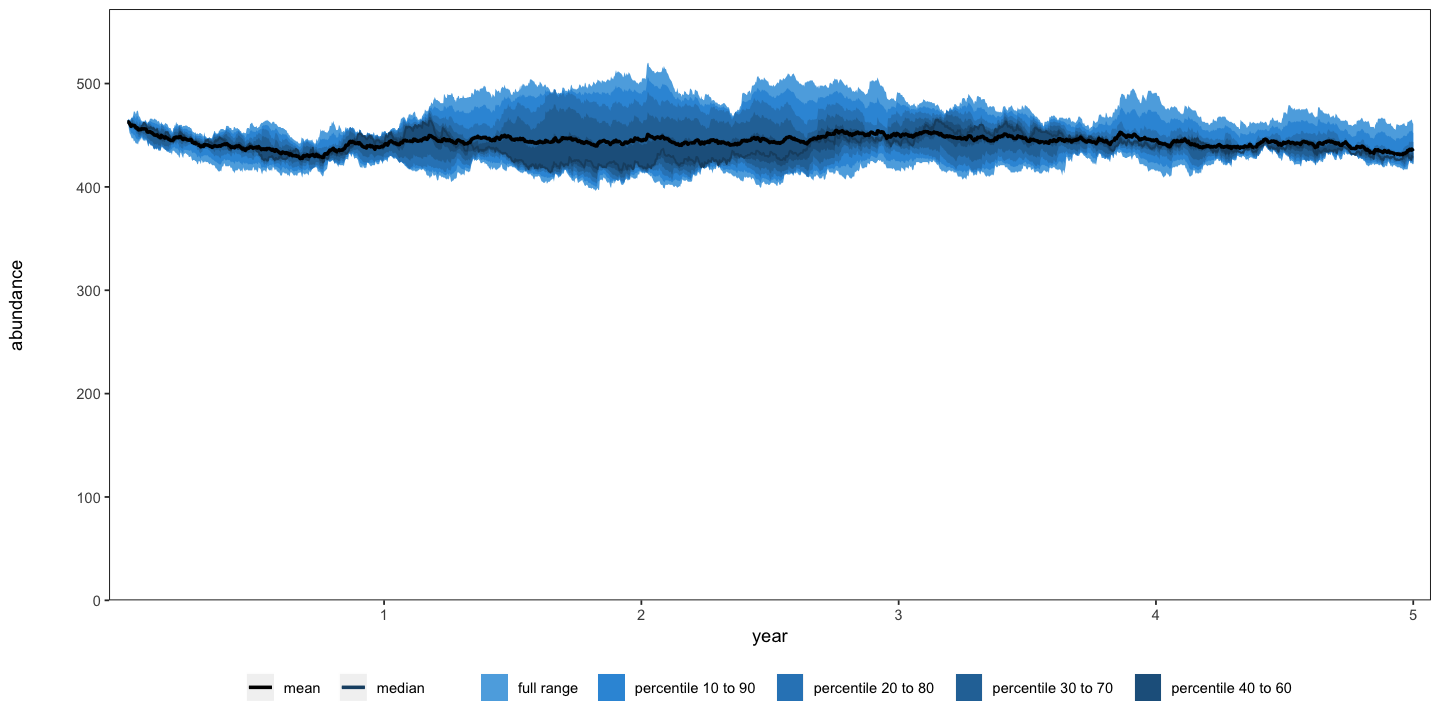

In [16]:
# Build Plots
abunMax         <- max(resultsMatrix[, 'abundance', ]) * 1.1
prevMax         <- max(resultsMatrix[, 'infective', ]) * 1.1
vaccMax         <- max(resultsMatrix[, 'vaccinated', ]) * 1.1
daySeries       <- seq(1, simulationEnd)

# Construct abundance plot:
quant0abun   <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.0)
quant10abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.1)
quant20abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.2)
quant30abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.3)
quant40abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.4)
quant50abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.5)
quant60abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.6)
quant70abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.7)
quant80abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.8)
quant90abun  <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 0.9)
quant100abun <- apply(resultsMatrix[, 'abundance', ], 1, quantile, 1.0)
meaNAbun = apply(resultsMatrix[, 'abundance', ], 1, mean, NA.rm=TRUE)

abundPlot <- ggplot() +
  geom_ribbon(aes(x=daySeries, ymax=quant100abun, ymin=quant0abun, fill='full range  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant90abun, ymin=quant10abun, fill='percentile 10 to 90  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant80abun, ymin=quant20abun, fill='percentile 20 to 80  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant70abun, ymin=quant30abun, fill='percentile 30 to 70  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant60abun, ymin=quant40abun, fill='percentile 40 to 60  ')) +
  geom_line(aes(daySeries, quant50abun, colour = 'median  ')) +
  geom_line(aes(daySeries, meaNAbun, colour = 'mean  '), size=1.0) +
  scale_x_continuous(limits=c(0, simulationEnd), expand = c(0, 25), breaks=c(365, 730, 1095, 1460, 1825),
                     labels = c('1', '2', '3', '4', '5')) +
  scale_y_continuous(limits=c(0, abunMax), expand = c(0, 0)) +
  ylab('abundance') +
  
  theme(axis.title.y=element_text(margin=margin(0,30,0,0))) +
  xlab('year') +
  theme(axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(fill=NA, colour='black'),
        panel.background = element_blank()) +
  scale_colour_manual(name=NULL, values=c('median  '='#1B4F72',
                                          'mean  '='black')) +
  scale_fill_manual(name=NULL, values=c('full range  '='#5DADE2',
                                        'percentile 10 to 90  '='#3498DB',
                                        'percentile 20 to 80  '='#2E86C1',
                                        'percentile 30 to 70  '='#2874A6',
                                        'percentile 40 to 60  '='#21618C')) +
  theme(legend.text.align=0) +
  theme(legend.position='bottom')

options(repr.plot.width=12, repr.plot.height=6)
print(abundPlot)

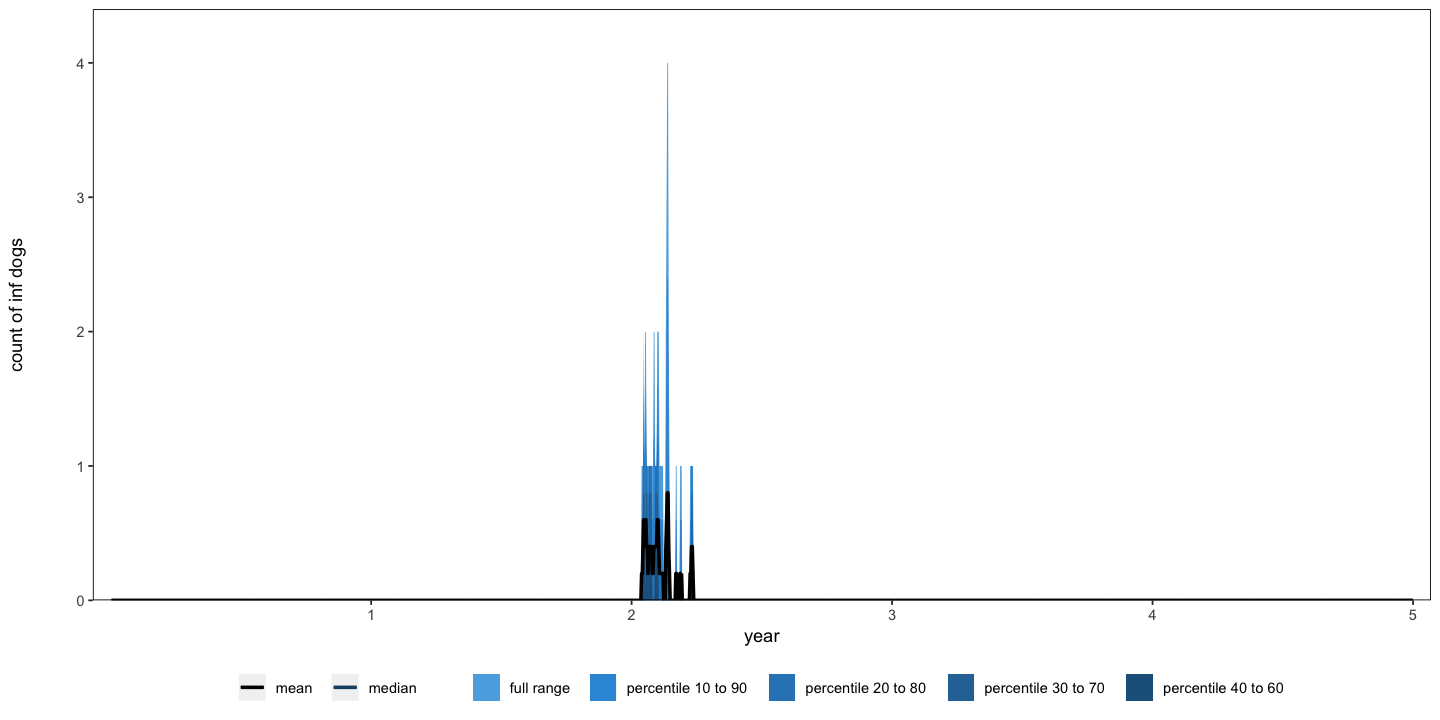

In [17]:
# Construct the disease prevalence plot:
quant0inf   <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.0)
quant10inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.1)
quant20inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.2)
quant30inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.3)
quant40inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.4)
quant50inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.5)
quant60inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.6)
quant70inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.7)
quant80inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.8)
quant90inf  <- apply(resultsMatrix[, 'infective', ], 1, quantile, 0.9)
quant100inf <- apply(resultsMatrix[, 'infective', ], 1, quantile, 1.0)
meanInf = apply(resultsMatrix[, 'infective', ], 1, mean, na.rm=TRUE)

infectPlot <- ggplot() +
  geom_ribbon(aes(x=daySeries, ymax=quant100inf, ymin=quant0inf, fill='full range  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant90inf, ymin=quant10inf, fill='percentile 10 to 90  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant80inf, ymin=quant20inf, fill='percentile 20 to 80  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant70inf, ymin=quant30inf, fill='percentile 30 to 70  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant60inf, ymin=quant40inf, fill='percentile 40 to 60  ')) +
  geom_line(aes(daySeries, quant50inf, colour = 'median  ')) +
  geom_line(aes(daySeries, meanInf, colour = 'mean  '), size=1.0) +
  scale_x_continuous(limits=c(0, simulationEnd), expand = c(0, 25), breaks=c(365, 730, 1095, 1460, 1825),
                     labels = c('1', '2', '3', '4', '5')) +
  scale_y_continuous(limits=c(0, prevMax), expand = c(0, 0)) +
  ylab('count of inf dogs') +
  theme(axis.title.y=element_text(margin=margin(0,30,0,0))) +
  #theme(axis.text=element_text(size=12, color='black'),
  #      axis.title=element_text(size=14, face="bold", color='black')) +
  xlab('year') +
  theme(axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(fill=NA, colour='black'),
        panel.background = element_blank()) +
  scale_colour_manual(name=NULL, values=c('median  '='#1B4F72',
                                          'mean  '='black')) +
  scale_fill_manual(name=NULL, values=c('full range  '='#5DADE2',
                                        'percentile 10 to 90  '='#3498DB',
                                        'percentile 20 to 80  '='#2E86C1',
                                        'percentile 30 to 70  '='#2874A6',
                                        'percentile 40 to 60  '='#21618C')) +
  theme(legend.text.align=0) +
  theme(legend.position='bottom')

options(repr.plot.width=12, repr.plot.height=6)
print(infectPlot)

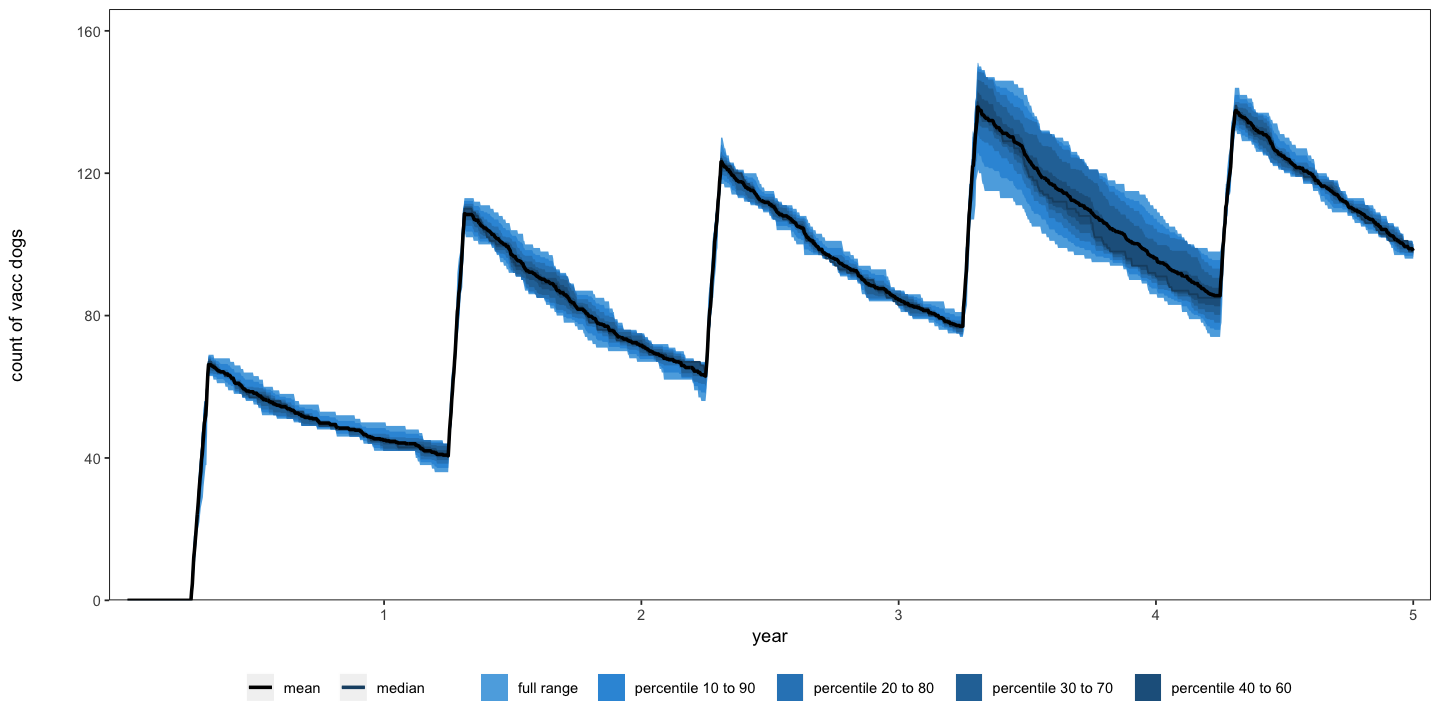

In [18]:
# Construct the vaccination plot:
quant0vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.0)
quant10vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.1)
quant20vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.2)
quant30vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.3)
quant40vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.4)
quant50vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.5)
quant60vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.6)
quant70vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.7)
quant80vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.8)
quant90vac  <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 0.9)
quant100vac <- apply(resultsMatrix[, 'vaccinated', ], 1, quantile, 1.0)
meanVac = apply(resultsMatrix[, 'vaccinated', ], 1, mean, na.rm=TRUE)

vaccPlot <- ggplot() +
  geom_ribbon(aes(x=daySeries, ymax=quant100vac, ymin=quant0vac, fill='full range  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant90vac, ymin=quant10vac, fill='percentile 10 to 90  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant80vac, ymin=quant20vac, fill='percentile 20 to 80  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant70vac, ymin=quant30vac, fill='percentile 30 to 70  ')) +
  geom_ribbon(aes(x=daySeries, ymax=quant60vac, ymin=quant40vac, fill='percentile 40 to 60  ')) +
  geom_line(aes(daySeries, quant50vac, colour = 'median  ')) +
  geom_line(aes(daySeries, meanVac, colour = 'mean  '), size=1.0) +
  scale_x_continuous(limits=c(0, simulationEnd), expand = c(0, 25), breaks=c(365, 730, 1095, 1460, 1825),
                     labels = c('1', '2', '3', '4', '5')) +
  scale_y_continuous(limits=c(0, vaccMax), expand = c(0, 0)) +
  ylab('count of vacc dogs') +
  theme(axis.title.y=element_text(margin=margin(0,30,0,0))) +
  #theme(axis.text=element_text(size=12, color='black'),
  #      axis.title=element_text(size=14, face="bold", color='black')) +
  xlab('year') + 
  theme(axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(fill=NA, colour='black'),
        panel.background = element_blank()) +
  scale_colour_manual(name=NULL, values=c('median  '='#1B4F72',
                                          'mean  '='black')) +
  scale_fill_manual(name=NULL, values=c('full range  '='#5DADE2',
                                        'percentile 10 to 90  '='#3498DB',
                                        'percentile 20 to 80  '='#2E86C1',
                                        'percentile 30 to 70  '='#2874A6',
                                        'percentile 40 to 60  '='#21618C')) +
  theme(legend.text.align=0) +
  theme(legend.position='bottom')

options(repr.plot.width=12, repr.plot.height=6)
print(vaccPlot)

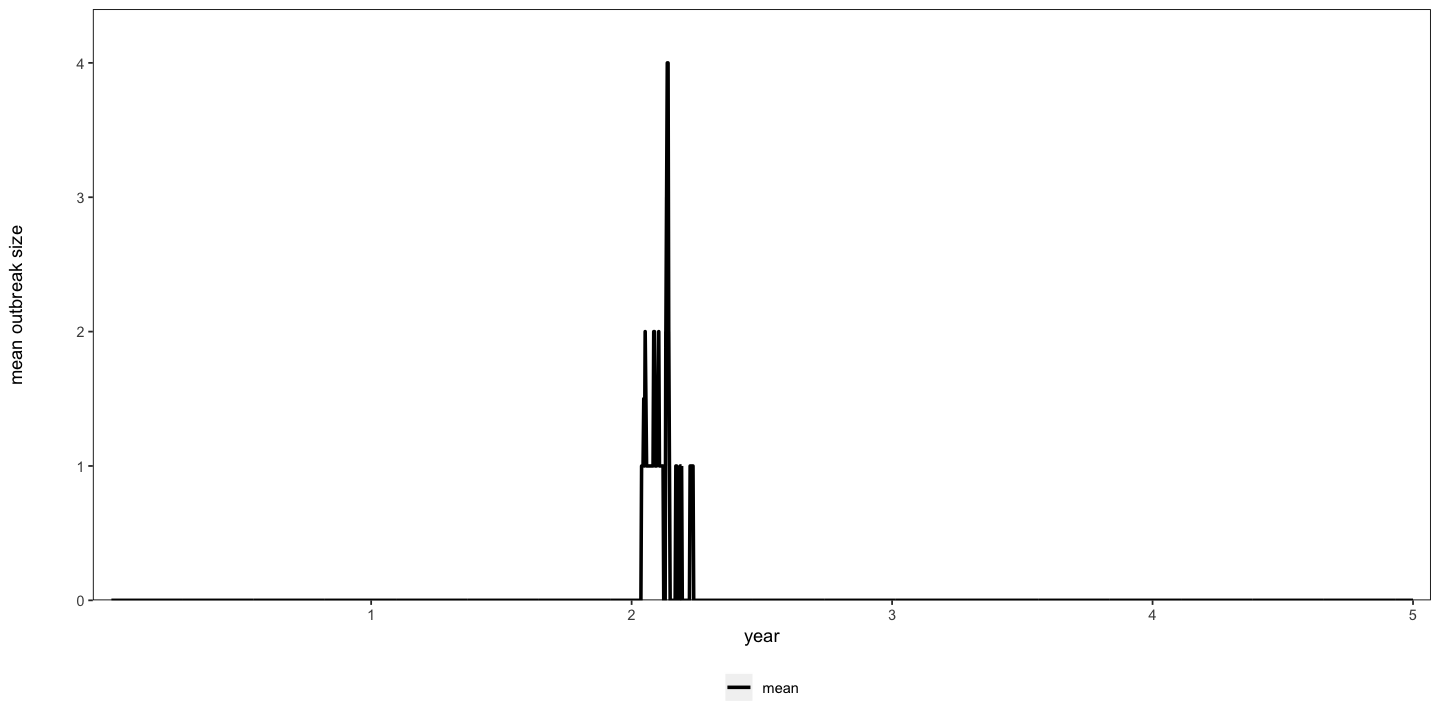

In [19]:
# Construct the outbreak size plot:
infective <- resultsMatrix[, 'infective', ]
totalInf <- rowSums(infective)
iterWithInf <- rowSums(infective > 0)
meanOutbreakSize <- totalInf / iterWithInf
meanOutbreakSize[meanOutbreakSize == 'NaN'] <- 0

outbreakPlot <- ggplot() +
  geom_line(aes(daySeries, meanOutbreakSize, colour = 'mean  '), size=1.0) +
  scale_x_continuous(limits=c(0, simulationEnd), expand = c(0, 25), breaks=c(365, 730, 1095, 1460, 1825),
                     labels = c('1', '2', '3', '4', '5')) +
  scale_y_continuous(limits=c(0, prevMax), expand = c(0, 0)) +
  ylab('mean outbreak size') +
  theme(axis.title.y=element_text(margin=margin(0,30,0,0))) +
  xlab('year') +
  theme(axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(fill=NA, colour='black'),
        panel.background = element_blank()) +
  scale_colour_manual(name=NULL, values=c('mean  '='black')) +
  theme(legend.text.align=0) +
  theme(legend.position='bottom')

options(repr.plot.width=12, repr.plot.height=6)
print(outbreakPlot)

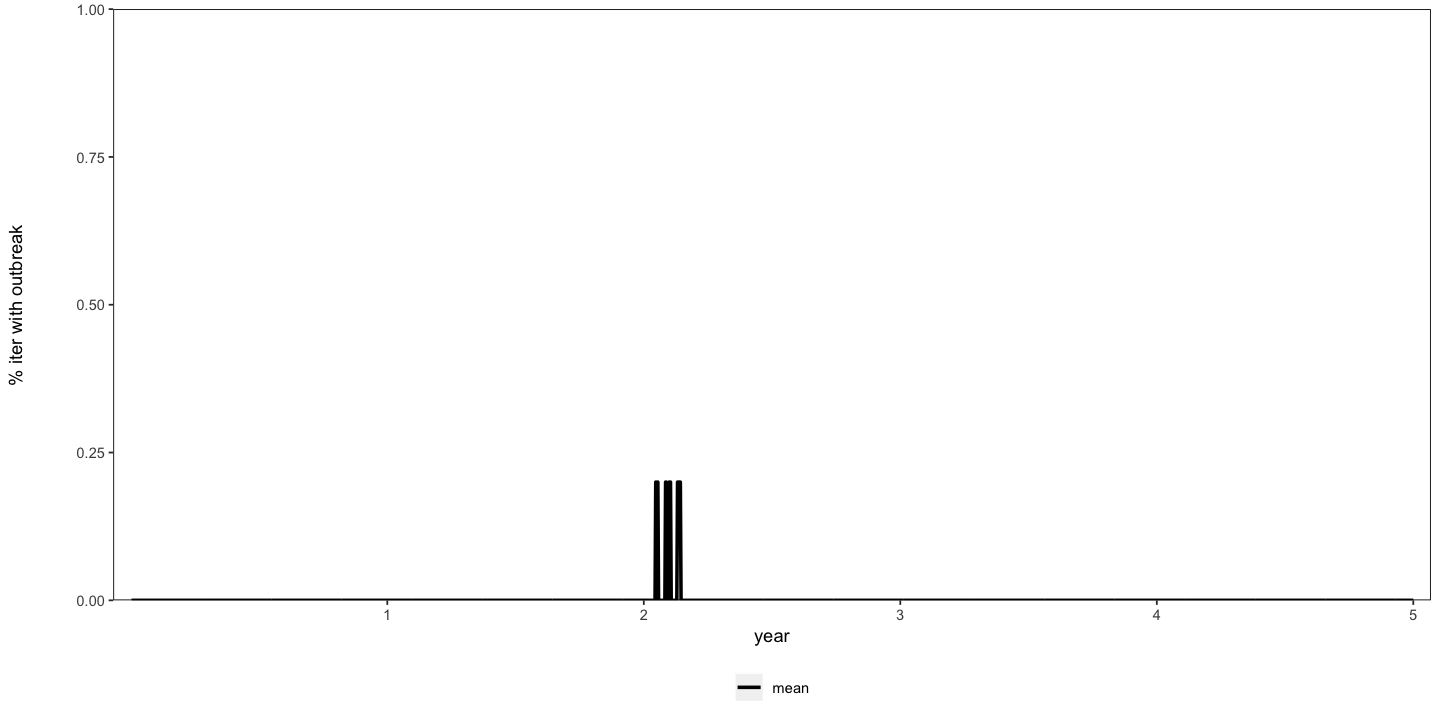

In [20]:
options(repr.plot.width=8, repr.plot.height=4)

# construct the outbreak probability plot
infective <- resultsMatrix[, 'infective', ] 
outbreakProb <- rowSums(infective > 1) / iterations
probPlot <- ggplot() +
  geom_line(aes(daySeries, outbreakProb, colour = 'mean  '), size=1.0) +
  scale_x_continuous(limits=c(0, simulationEnd), expand = c(0, 25), breaks=c(365, 730, 1095, 1460, 1825),
                     labels = c('1', '2', '3', '4', '5')) +
  scale_y_continuous(limits=c(0, 1), expand = c(0, 0)) +
  ylab('% iter with outbreak') +
  theme(axis.title.y=element_text(margin=margin(0,30,0,0))) +
  #theme(axis.text=element_text(size=12, color='black'),
  #      axis.title=element_text(size=14, face="bold", color='black')) +
  xlab('year') +
  theme(axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(fill=NA, colour='black'),
        panel.background = element_blank()) +
  scale_colour_manual(name=NULL, values=c('mean  '='black')) +
  theme(legend.text.align=0) +
  theme(legend.position='bottom')

options(repr.plot.width=12, repr.plot.height=6)
print(probPlot)

---